In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [2]:
transform   = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

trainset    = datasets.MNIST('train', download = True, train = True , transform = transform)
valset      = datasets.MNIST('val  ', download = True, train = False, transform = transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle = True)
valloader   = torch.utils.data.DataLoader(valset  , batch_size = 64, shuffle = True)

In [3]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
# torch.Size([64, 1, 28, 28])
# training data : 28 by 28 pixel images
print(labels.shape)
# torch.Size([64])

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [4]:
input_size   = 28*28
hidden_sizes = [128, 64]
# two layers
# the first hidden layer : 128
# the second hidden layer : 64

output_size  = 10

sizes = [input_size] + hidden_sizes

layers  = sum([[nn.Linear(start, end), nn.ReLU()] for start, end in zip(sizes, sizes[1:])], [])
layers += [nn.Linear(sizes[-1], output_size), nn.LogSoftmax(dim = 1)]

model = nn.Sequential(*layers)

print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


In [5]:
criterion      = nn.NLLLoss()
images, labels = next(iter(trainloader))
images         = images.view(images.shape[0], -1)

logps = model(images)            # log probabilities
loss  = criterion(logps, labels) # calculate the NLL loss

In [6]:
optimizer = optim.Adam(model.parameters(), lr = 1e-2)
# Adam : a method like SDG and DG
time0     = time()
epochs    = 15

for e in range(1, epochs + 1):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()

    print(f"Epoch {e:3d} - Training loss: {running_loss / len(trainloader)}")

m, s = map(int, divmod(time() - time0, 60))
if s == 60:
    m += 1
    s  = 0
print(f"\nTraining Time = {m:d}m {s:d}s")

Epoch   1 - Training loss: 0.3889930016085156
Epoch   2 - Training loss: 0.2532378752618583
Epoch   3 - Training loss: 0.22523869513305647
Epoch   4 - Training loss: 0.21686284710118955
Epoch   5 - Training loss: 0.2077731676916006
Epoch   6 - Training loss: 0.20428651837663833
Epoch   7 - Training loss: 0.20456423198701
Epoch   8 - Training loss: 0.19802536479513178
Epoch   9 - Training loss: 0.1902443439419717
Epoch  10 - Training loss: 0.18696987153942396
Epoch  11 - Training loss: 0.17919936519402113
Epoch  12 - Training loss: 0.18355557064849462
Epoch  13 - Training loss: 0.17716233468160772
Epoch  14 - Training loss: 0.17940411035384515
Epoch  15 - Training loss: 0.1757362850555487

Training Time = 3m 45s


In [7]:
images, labels = next(iter(valloader))

img = images.view(-1, 784)
with torch.no_grad():
    logps = model(img)

ps = torch.exp(logps)

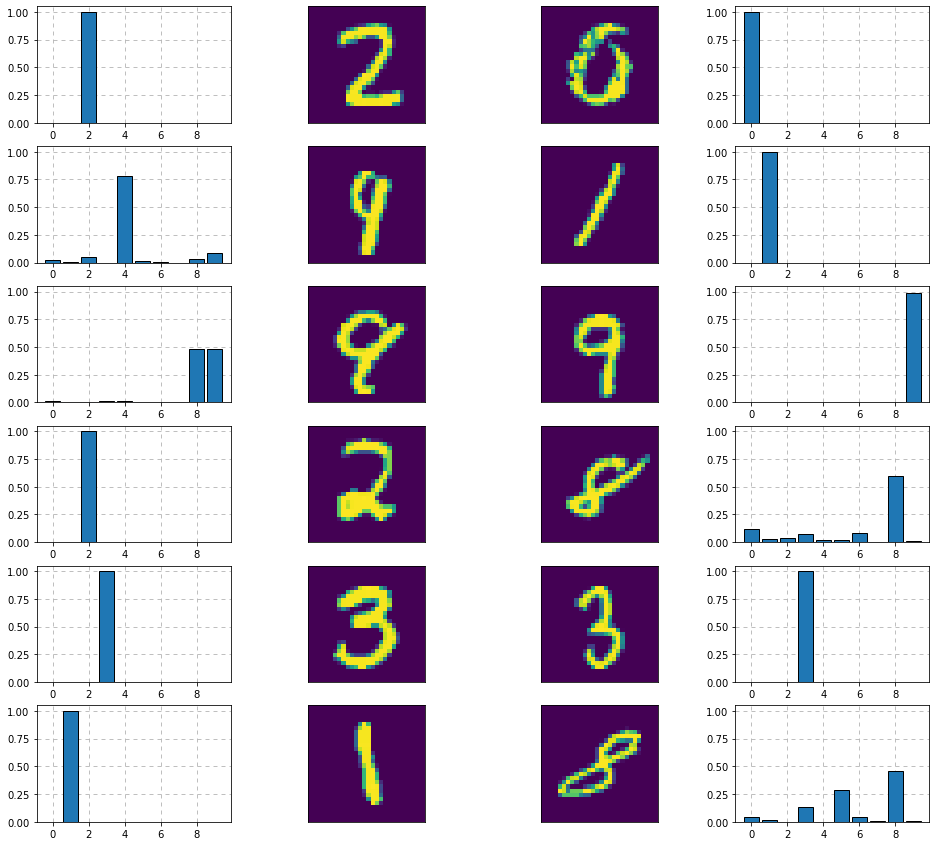

In [8]:
fig, ax = plt.subplots(6, 4, figsize = (16, 15))

for i in range(6):
    ax[i,0].bar(range(10), ps.numpy()[i * 2], ec = 'k', zorder = 3)
    ax[i,1].imshow(images.numpy()[i * 2, 0])
    ax[i,2].imshow(images.numpy()[i * 2 + 1, 0])
    ax[i,3].bar(range(10), ps.numpy()[i * 2 + 1], ec = 'k', zorder = 3)
    
    for j in [1, 2]:
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])

    for j in [0, 3]:
        ax[i,j].set_ylim((0, 1.05))
        ax[i,j].grid(ls = (0, (5, 5)))

In [9]:
y_hat  = []
y_true = []
with torch.no_grad():
    for images, label in valloader:
        images = images.view(-1, 784)
        logp   = model(images)
        y_hat.append(logp.numpy().argmax(axis = -1))
        y_true.append(label.numpy())

y_hat  = np.concatenate(y_hat)
y_true = np.concatenate(y_true)

(y_hat == y_true).mean()

0.9534

In [10]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_hat, normalize = 'true')

cm.round(2)

array([[0.98, 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.01, 0.  ],
       [0.  , 0.97, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  ],
       [0.  , 0.  , 0.94, 0.03, 0.  , 0.  , 0.  , 0.01, 0.02, 0.  ],
       [0.  , 0.  , 0.  , 0.97, 0.  , 0.01, 0.  , 0.  , 0.01, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.93, 0.  , 0.02, 0.  , 0.01, 0.03],
       [0.  , 0.  , 0.  , 0.03, 0.  , 0.91, 0.02, 0.  , 0.03, 0.  ],
       [0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.97, 0.  , 0.01, 0.  ],
       [0.  , 0.  , 0.01, 0.01, 0.  , 0.  , 0.  , 0.95, 0.01, 0.01],
       [0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.01, 0.  , 0.96, 0.  ],
       [0.01, 0.  , 0.  , 0.01, 0.01, 0.  , 0.  , 0.01, 0.03, 0.93]])

In [11]:
r = cm.shape[0]
min_list = []
for i in range(r):
    min_list.append(max(cm.round(2)[i]))


    
min_value = min(min_list)
min_index = min_list.index(min_value)

print("min_value is {} and the corresponding index is {}.".format(min_value, min_index))

min_value is 0.91 and the corresponding index is 5.
